In [24]:
# !pip install sentence_transformers
# !pip install git+https://github.com/huggingface/transformers.git
# !pip install xgboost
# !pipreqs

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x7ef420245f00>> (for pre_run_cell):


In [1]:
import os
os.chdir("..")
print(os.listdir())
from utils.utils import notebook_line_magic
notebook_line_magic()

['README.md', 'figures', 'data', '.DS_Store', 'utils', 'notebooks', 'models', '.gitignore', 'train.sh', '.git', 'scalar_training_log.log', 'train.py', 'training_log.log', 'app.py', '__pycache__']
Line Magic Set


### Data Exploration 
- The nlp dataset has vector of inconsistent lenghts.
- Couple of options (among many):
- Since each integer represents a token. Each vector can be padded with an unused integer to make all vector have a consistent lenght -> then do PCA if needed to reduce dimensions.
- Use a pretrained encoder to generate embeddings.


## data processing
- manually add padding and use sentence transformer to generate embeddings
- use auto tokenize with padding
- manually add padding and then do tf-idf

## modeling ideas
- create a dataloader with a defined bacth size
- use the dataloader to create embeddings and then merge with the UniqueID
- combined embeddings with other features
- build an XGBoost model and a custom torch fully connected network
- you can als get fancy with concatenating the bert model above with a torch classifier 
- knn classifier might also work well with features and embeddings

In [2]:
# add padding to the tokens
import ast
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict



from models.pca import get_pca_components
from models.xgboost_train_predict import search_best_params
from utils.data_utils import (
    get_data_df, get_padded_tokens, generate_embeddings_from_tokens
)
from utils.utils import (
    plot_class_distribution, plot_pca_components_and_variance,
    generate_2d_pca_distribution_plot, generate_3d_pca_distribution_plot
)

In [3]:
data_path = 'data'
data_type = 'train'
data_path = Path(data_path)
embeddings_file = f'x_{data_type}_nlp_embeddings.csv'
embeddings_file_path = data_path/data_type/embeddings_file

# combine embeddings with other features for modeling
embeddings_df = pd.read_csv(embeddings_file_path).drop(columns=['Unnamed: 0'])
data_df = get_data_df(data_type='train')
data_df = data_df.merge(embeddings_df, on='UniqueID', how='inner')
data_df.set_index('UniqueID', inplace=True)
# data_df.drop(columns=['nlp_feature_vector'], inplace=True)

# x = data_df[data_df.columns[~data_df.columns.isin(['Target'])]]
# y = data_df['Target']

In [22]:
# inconsistent input size
# temp = [np.array(eval(i)) for i in data_df.iloc[0:3]['nlp_feature_vector'].values]
# for i in temp:
#     print(i.shape)


features = data_df[['Feature1', 'Feature2', 'Feature3', 'Feature4']]
features.describe().round(2)

,Feature1,Feature2,Feature3,Feature4
count,25000.00,25000.00,25000.00,25000.00
mean,1.22,1.23,16.00,-0.00
std,1.77,1.77,1.50,1.52
min,-4.59,-4.08,9.91,-7.79
25%,-0.08,-0.06,14.98,-1.03
50%,1.24,1.25,15.99,-0.00
75%,2.48,2.47,17.01,1.03
max,7.59,7.60,21.73,6.00


In [ ]:
# plot PCA components
# for c in [2,100, 200, 300, 500]:
#     mod, z, z0 = get_pca_components(data=x, num_components=c)
#     plot_pca_components_and_variance(mod, save_fig=True)
# plot_class_distribution(target=y, save_fig=True)

- based on above it seems like having more features will continue to boost performance
- so maybe not reduce dimensionality while fitting the model
- a deep learning model may work well compared to a tree based model but it could potentially overfit to the data too.. experiment and find out

In [151]:
mod, z, z0 = get_pca_components(data=x, num_components=3)

PCA Components Shape: (25000, 3)


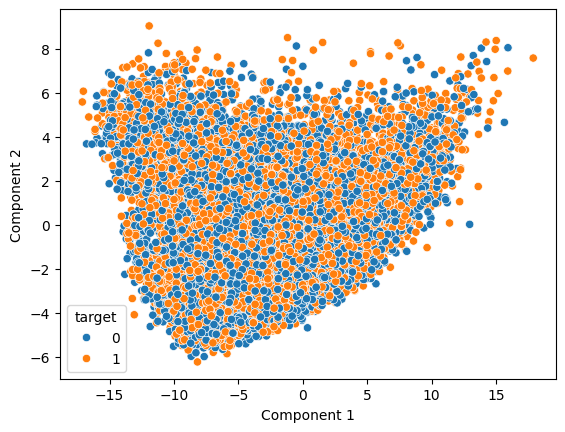

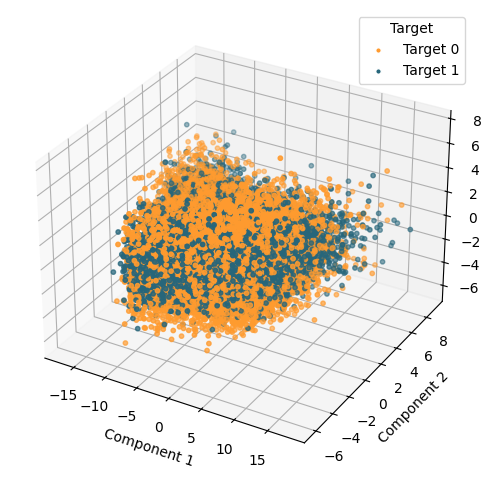

In [ ]:
generate_2d_pca_distribution_plot(
    components=z0,
    target=y
)
generate_3d_pca_distribution_plot(
    components=z0,
    target=y
)

In [228]:
search_best_params()

train accuracy: 0.7466 | test accuracy: 0.7188 | test auc: 0.7188 | depth: 4 | n_estimators: 10 | subsamples: 0.1 | learning rate: 0.1 | colsample_bytree: 0.1
train accuracy: 0.72165 | test accuracy: 0.684 | test auc: 0.6839999999999999 | depth: 6 | n_estimators: 10 | subsamples: 0.1 | learning rate: 0.1 | colsample_bytree: 0.1
train accuracy: 0.71765 | test accuracy: 0.6538 | test auc: 0.6538 | depth: 8 | n_estimators: 10 | subsamples: 0.1 | learning rate: 0.1 | colsample_bytree: 0.1
train accuracy: 0.71685 | test accuracy: 0.6352 | test auc: 0.6352 | depth: 10 | n_estimators: 10 | subsamples: 0.1 | learning rate: 0.1 | colsample_bytree: 0.1
train accuracy: 0.71675 | test accuracy: 0.6314 | test auc: 0.6314 | depth: 12 | n_estimators: 10 | subsamples: 0.1 | learning rate: 0.1 | colsample_bytree: 0.1
train accuracy: 0.72085 | test accuracy: 0.6308 | test auc: 0.6308 | depth: 14 | n_estimators: 10 | subsamples: 0.1 | learning rate: 0.1 | colsample_bytree: 0.1
train accuracy: 0.71645 | t

KeyboardInterrupt: 